In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy import stats


In [2]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)


In [3]:
airports = pd.read_csv("data/Airports Data.csv")
bag_level = pd.read_csv("data/Bag+Level+Data.csv")
flight_level = pd.read_csv("data/Flight Level Data.csv")
pnr_remark_level = pd.read_csv("data/PNR Remark Level Data.csv")
pnr_flight_level = pd.read_csv("data/PNR+Flight+Level+Data.csv")

DATA CLEANING

LOADING DATA

Cleaning flight data...
Dropping 312 flights with negative ground times
Dropping 0 time travel flights
Dropping 0 flights with extreme delays (>24 hours)
Dropping 17 flights <15 min and 16 flights >20 hours
Dropping 0 same-airport flights
Removed 9 duplicates

✓ Final flight dataset: 7,752 flights

FEATURE ENGINEERING FOR DIFFICULTY SCORE
✓ Ground time ratio calculated
✓ Bag complexity metrics calculated
✓ Passenger load calculated
✓ SSR counts calculated
✓ Child complexity metrics calculated

Merging all features...
✓ Enhanced dataset: 7,776 flights with 27 features

CALCULATING FLIGHT DIFFICULTY SCORE

📋 Difficulty Components & Weights:
------------------------------------------------------------
Component                           Weight     Logic
------------------------------------------------------------
Transfer Bags (absolute)            0.25       More transfers = complexity
SSR Count                           0.20       More SSRs = complexity
Ground Time Pressur

/tmp/ipykernel_114381/3983310341.py:462: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


✓ Saved: daily_ranking_analysis.png


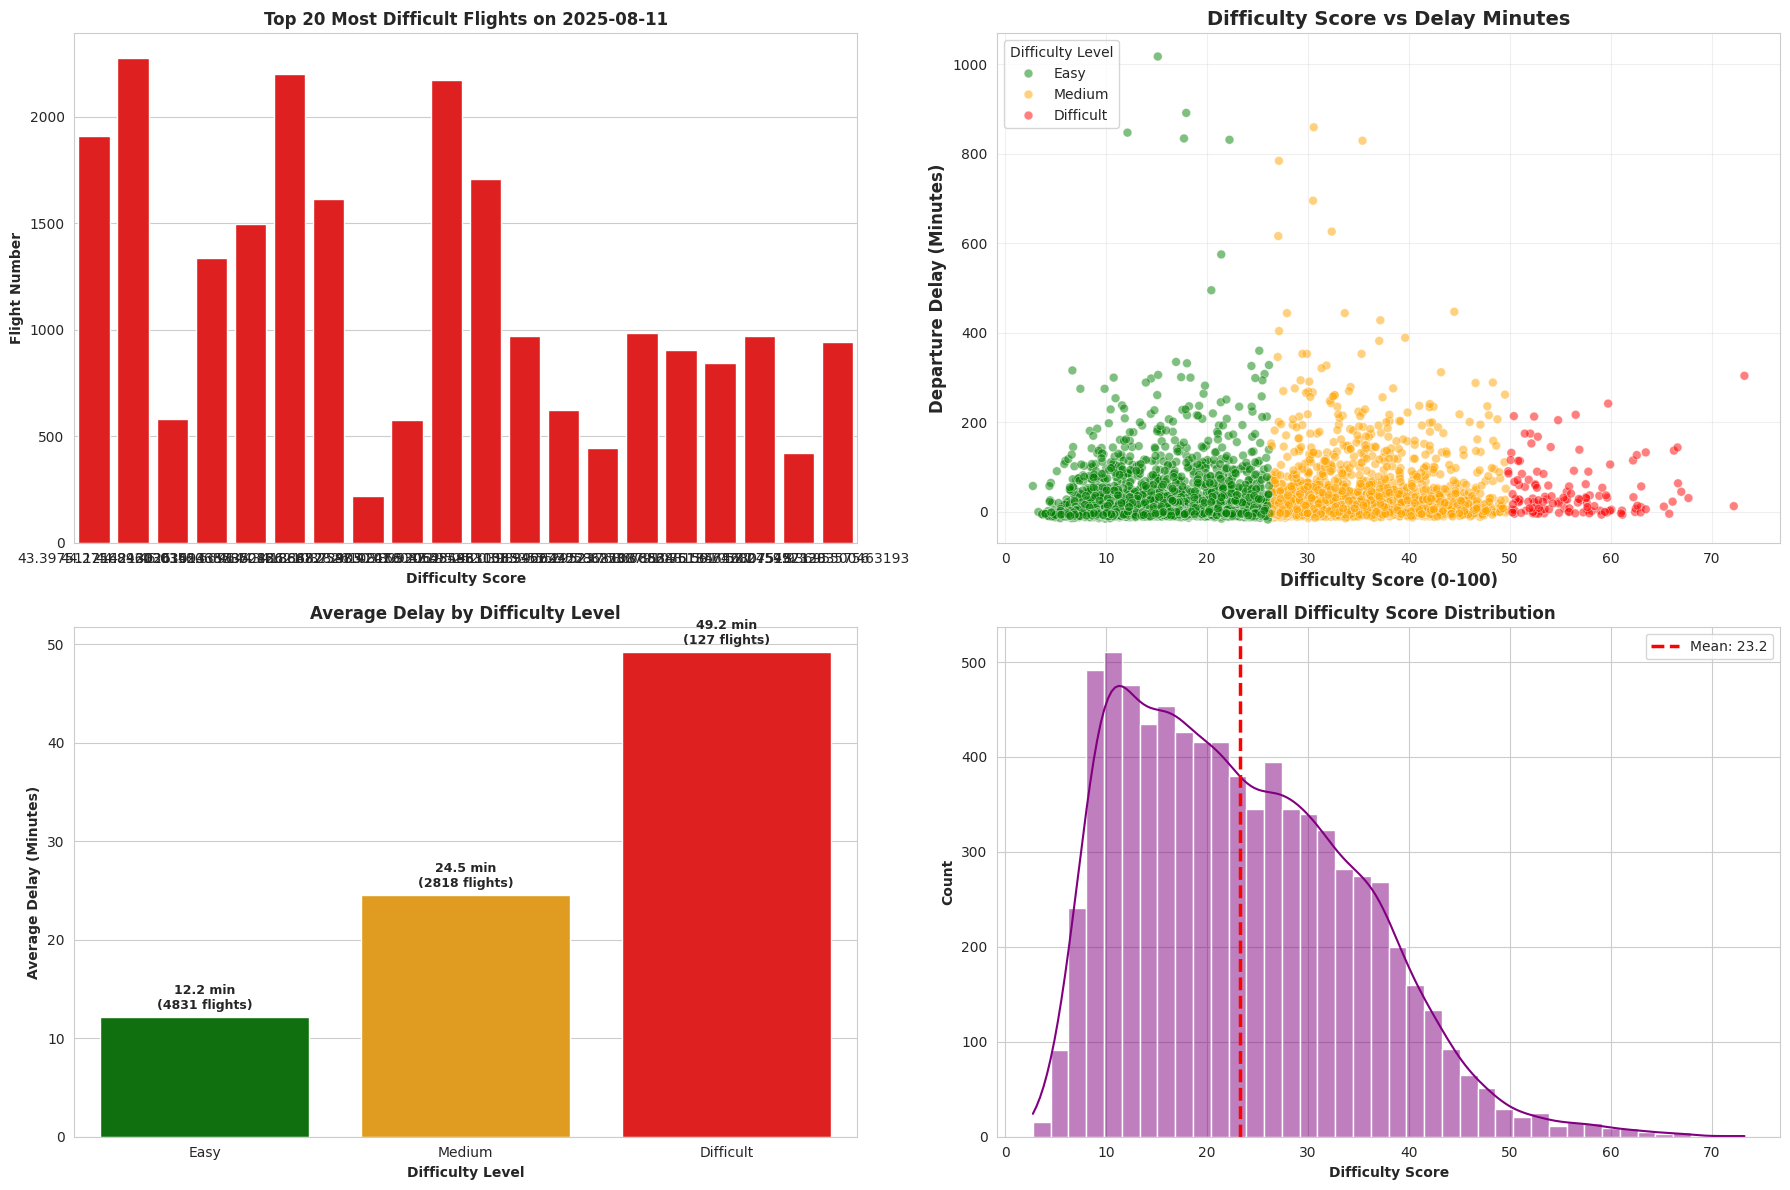

/tmp/ipykernel_114381/3983310341.py:510: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_114381/3983310341.py:529: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


✓ Saved: destination_difficulty_analysis.png


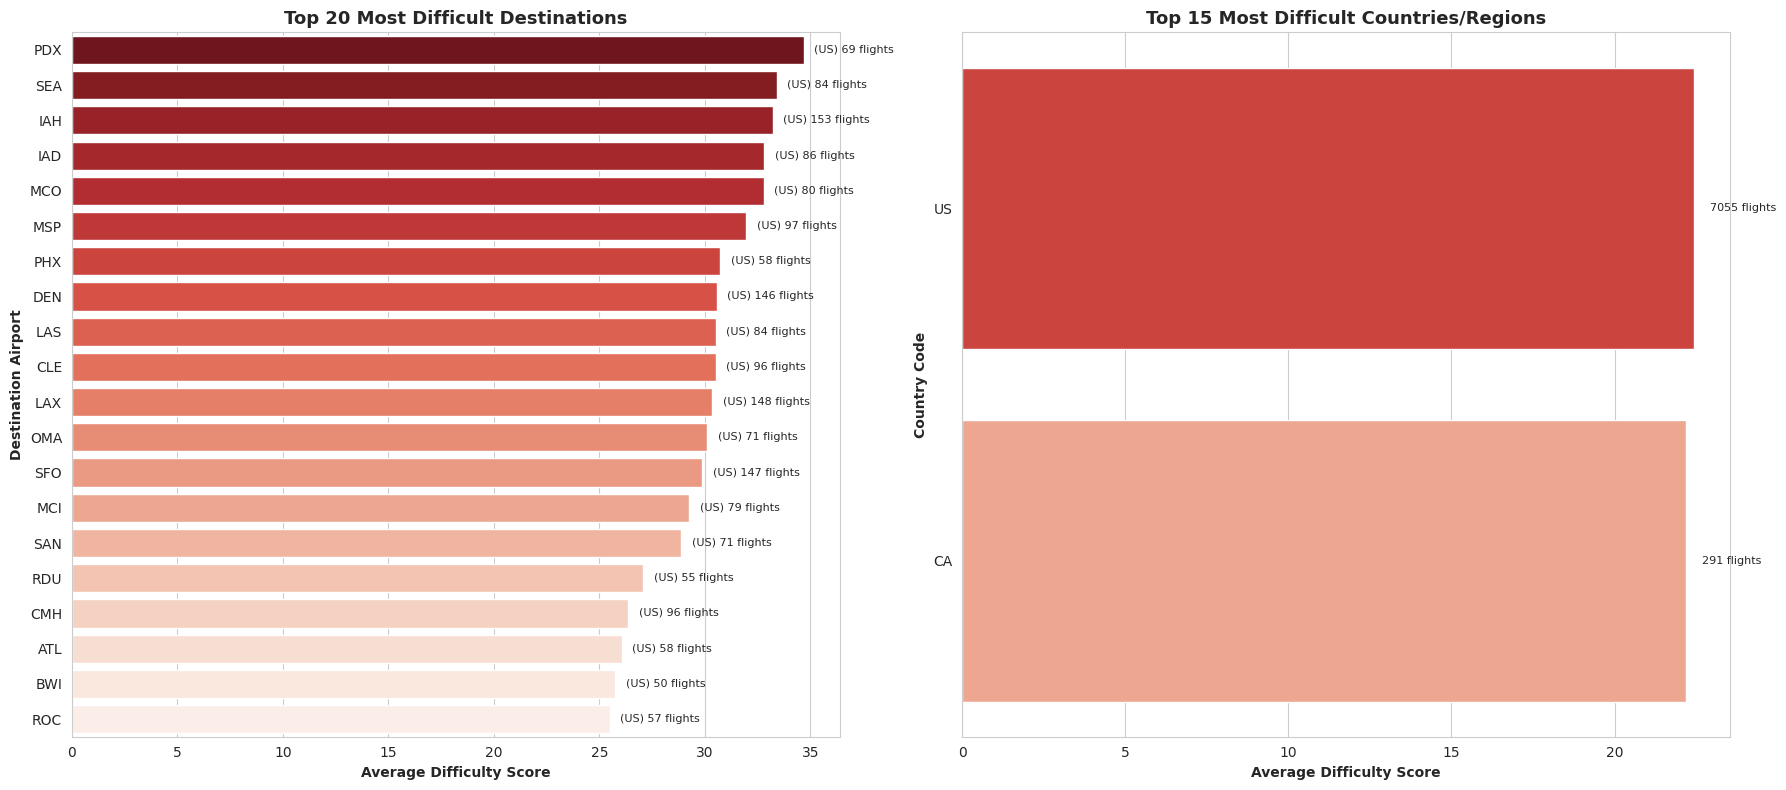


EXPORTING RESULTS
✓ Exported 7,776 flights with daily rankings
✓ Exported 61 destinations
✓ Exported 2 countries

SUMMARY STATISTICS

Difficulty Score Range: 2.72 - 73.25
Mean Difficulty Score: 23.22
Median Difficulty Score: 21.68

📊 Average Delay by Difficulty Level:
------------------------------------------------------------
difficulty_level  mean_delay  median_delay  flight_count
            Easy       12.15          -2.0          4831
          Medium       24.51           4.0          2818
       Difficult       49.24          28.0           127

✅ ANALYSIS COMPLETE

Files Generated:
  1. daily_ranking_analysis.png
  2. destination_difficulty_analysis.png
  3. daily_flight_difficulty_rankings.csv
  4. destination_difficulty_analysis.csv
  5. country_difficulty_analysis.csv


In [ ]:

# Drop invalid ground times
invalid = (flight_level['scheduled_ground_time_minutes'] <= 0).sum()
print(f"Dropping {invalid} flights with negative ground times")
flight_level = flight_level[flight_level['scheduled_ground_time_minutes'] >= 0].copy()

# Convert datetime columns
flight_level['scheduled_departure_datetime_local'] = pd.to_datetime(
    flight_level['scheduled_departure_datetime_local']
)
flight_level['actual_departure_datetime_local'] = pd.to_datetime(
    flight_level['actual_departure_datetime_local']
)
flight_level['scheduled_arrival_datetime_local'] = pd.to_datetime(
    flight_level['scheduled_arrival_datetime_local']
)
flight_level['scheduled_departure_date_local'] = pd.to_datetime(
    flight_level['scheduled_departure_date_local']
)

# Remove time travel flights
time_travel = (flight_level['actual_arrival_datetime_local'] < flight_level['actual_departure_datetime_local']).sum()
print(f"Dropping {time_travel:,} time travel flights")
flight_level = flight_level[flight_level['actual_arrival_datetime_local'] >= flight_level['actual_departure_datetime_local']].copy()

# Calculate delay
if 'delay_minutes' not in flight_level.columns:
    flight_level['delay_minutes'] = (
        flight_level['actual_departure_datetime_local'] - 
        flight_level['scheduled_departure_datetime_local']
    ).dt.total_seconds() / 60

# Remove extreme delays
extreme_delays = (flight_level['delay_minutes'] > 1440).sum()
print(f"Dropping {extreme_delays:,} flights with extreme delays (>24 hours)")
flight_level = flight_level[flight_level['delay_minutes'] <= 1440].copy()

# Calculate scheduled duration
flight_level['scheduled_duration_minutes'] = (
    flight_level['scheduled_arrival_datetime_local'] - 
    flight_level['scheduled_departure_datetime_local']
).dt.total_seconds() / 60

# Remove impossible durations
too_short = (flight_level['scheduled_duration_minutes'] < 15).sum()
too_long = (flight_level['scheduled_duration_minutes'] > 1200).sum()
print(f"Dropping {too_short:,} flights <15 min and {too_long:,} flights >20 hours")
flight_level = flight_level[
    (flight_level['scheduled_duration_minutes'] >= 15) & 
    (flight_level['scheduled_duration_minutes'] <= 1200)
].copy()

# Remove same airport flights
same_airport = (flight_level['scheduled_departure_station_code'] == flight_level['scheduled_arrival_station_code']).sum()
print(f"Dropping {same_airport:,} same-airport flights")
flight_level = flight_level[flight_level['scheduled_departure_station_code'] != flight_level['scheduled_arrival_station_code']].copy()

# Remove duplicates
before_dup = len(flight_level)
flight_level = flight_level.drop_duplicates(subset=['scheduled_departure_datetime_local', 'flight_number'], keep='first')
print(f"Removed {before_dup - len(flight_level)} duplicates")

# Remove fleet_type if exists
if 'fleet_type' in flight_level.columns:
    flight_level = flight_level.drop(columns=['fleet_type'])

print(f"\n✓ Final flight dataset: {len(flight_level):,} flights\n")

# ============================================================================
# FEATURE ENGINEERING
# ============================================================================

print("="*80)
print("FEATURE ENGINEERING FOR DIFFICULTY SCORE")
print("="*80)

# 1. GROUND TIME PRESSURE
flight_level['ground_time_ratio'] = (
    flight_level['scheduled_ground_time_minutes'] / 
    flight_level['minimum_turn_minutes']
)
print("✓ Ground time ratio calculated")

# 2. BAG HANDLING COMPLEXITY
bag_summary = bag_level.groupby(
    ['company_id', 'flight_number', 'scheduled_departure_date_local', 
     'scheduled_departure_station_code', 'scheduled_arrival_station_code']
).agg(
    total_bags=('bag_tag_unique_number', 'count'),
    transfer_bags=('bag_type', lambda x: x.isin(['Transfer', 'Hot Transfer']).sum())
).reset_index()

bag_summary['checked_bags'] = bag_summary['total_bags'] - bag_summary['transfer_bags']
bag_summary['transfer_ratio'] = bag_summary['transfer_bags'] / bag_summary['total_bags']

# Convert date for merge
bag_summary['scheduled_departure_date_local'] = pd.to_datetime(bag_summary['scheduled_departure_date_local'])
print("✓ Bag complexity metrics calculated")

# 3. PASSENGER LOAD
unique_pnrs = pnr_flight_level.drop_duplicates(
    subset=['company_id', 'flight_number', 'scheduled_departure_date_local', 'record_locator']
)
passenger_load = unique_pnrs.groupby(
    ['company_id', 'flight_number', 'scheduled_departure_date_local']
)['total_pax'].sum().reset_index()
passenger_load = passenger_load.rename(columns={'total_pax': 'total_passengers'})
passenger_load['scheduled_departure_date_local'] = pd.to_datetime(passenger_load['scheduled_departure_date_local'])
print("✓ Passenger load calculated")

# 4. SSR COUNT (Special Service Requests)
ssr_by_flight = pnr_remark_level.groupby('flight_number').size().reset_index(name='ssr_count')
print("✓ SSR counts calculated")

# 5. CHILD-RELATED COMPLEXITY
child_summary = pnr_flight_level.groupby(
    ['company_id', 'flight_number', 'scheduled_departure_date_local']
).agg(
    total_children=('is_child', lambda x: (x == 'Y').sum()),
    total_lap_children=('lap_child_count', 'sum'),
    total_stroller_users=('is_stroller_user', lambda x: (x == 'Y').sum())
).reset_index()

child_summary['total_child_complexity'] = (
    child_summary['total_children'] + 
    child_summary['total_lap_children'] + 
    child_summary['total_stroller_users']
)
child_summary['scheduled_departure_date_local'] = pd.to_datetime(child_summary['scheduled_departure_date_local'])
print("✓ Child complexity metrics calculated")

# ============================================================================
# MERGE ALL FEATURES
# ============================================================================

print("\nMerging all features...")

# Merge bag data
flight_enhanced = flight_level.merge(
    bag_summary[['company_id', 'flight_number', 'scheduled_departure_date_local', 
                 'total_bags', 'transfer_bags', 'transfer_ratio']],
    on=['company_id', 'flight_number', 'scheduled_departure_date_local'],
    how='left'
)

# Merge passenger data
flight_enhanced = flight_enhanced.merge(
    passenger_load,
    on=['company_id', 'flight_number', 'scheduled_departure_date_local'],
    how='left'
)

# Merge SSR data
flight_enhanced = flight_enhanced.merge(
    ssr_by_flight,
    on='flight_number',
    how='left'
)

# Merge child complexity data
flight_enhanced = flight_enhanced.merge(
    child_summary,
    on=['company_id', 'flight_number', 'scheduled_departure_date_local'],
    how='left'
)

# Calculate load factor
flight_enhanced['load_factor'] = (
    flight_enhanced['total_passengers'] / flight_enhanced['total_seats']
) * 100

# Fill missing values
flight_enhanced['total_bags'] = flight_enhanced['total_bags'].fillna(0)
flight_enhanced['transfer_bags'] = flight_enhanced['transfer_bags'].fillna(0)
flight_enhanced['transfer_ratio'] = flight_enhanced['transfer_ratio'].fillna(0)
flight_enhanced['total_passengers'] = flight_enhanced['total_passengers'].fillna(0)
flight_enhanced['load_factor'] = flight_enhanced['load_factor'].fillna(0)
flight_enhanced['ssr_count'] = flight_enhanced['ssr_count'].fillna(0)
flight_enhanced['total_children'] = flight_enhanced['total_children'].fillna(0)
flight_enhanced['total_lap_children'] = flight_enhanced['total_lap_children'].fillna(0)
flight_enhanced['total_stroller_users'] = flight_enhanced['total_stroller_users'].fillna(0)
flight_enhanced['total_child_complexity'] = flight_enhanced['total_child_complexity'].fillna(0)

print(f"✓ Enhanced dataset: {len(flight_enhanced):,} flights with {flight_enhanced.shape[1]} features\n")

# ============================================================================
# DIFFICULTY SCORE CALCULATION
# ============================================================================

print("="*80)
print("CALCULATING FLIGHT DIFFICULTY SCORE")
print("="*80)

# Normalize features to 0-1 scale
def normalize_feature(series, clip_percentile=99):
    """Normalize to 0-1, clipping extreme outliers"""
    clipped = series.clip(upper=series.quantile(clip_percentile/100))
    min_val = clipped.min()
    max_val = clipped.max()
    if max_val == min_val:
        return series * 0
    return (clipped - min_val) / (max_val - min_val)

# Create normalized versions
flight_enhanced['norm_transfer_bags'] = normalize_feature(flight_enhanced['transfer_bags'])
flight_enhanced['norm_ssr_count'] = normalize_feature(flight_enhanced['ssr_count'])
flight_enhanced['norm_child_complexity'] = normalize_feature(flight_enhanced['total_child_complexity'])

# Ground time: INVERSE (tighter turnaround = higher difficulty)
flight_enhanced['norm_ground_pressure'] = 1 - normalize_feature(
    flight_enhanced['ground_time_ratio'].clip(lower=0.8, upper=2.0)
)

# Load factor: INVERSE (lower load = higher difficulty, poorly organized)
flight_enhanced['norm_load_inefficiency'] = 1 - normalize_feature(flight_enhanced['load_factor'])

# Weights based on operational impact
weights = {
    'norm_transfer_bags': 0.25,        # Transfer bags add complexity
    'norm_ssr_count': 0.20,            # Special service requests
    'norm_ground_pressure': 0.15,      # Tight turnarounds
    'norm_load_inefficiency': 0.30,    # Load factor efficiency
    'norm_child_complexity': 0.10      # Children/lap children/strollers
}

print("\n📋 Difficulty Components & Weights:")
print("-" * 60)
print(f"{'Component':<35} {'Weight':<10} {'Logic'}")
print("-" * 60)
print(f"{'Transfer Bags (absolute)':<35} {weights['norm_transfer_bags']:<10.2f} More transfers = complexity")
print(f"{'SSR Count':<35} {weights['norm_ssr_count']:<10.2f} More SSRs = complexity")
print(f"{'Ground Time Pressure':<35} {weights['norm_ground_pressure']:<10.2f} Tight turns = difficulty")
print(f"{'Load Inefficiency':<35} {weights['norm_load_inefficiency']:<10.2f} Low loads = poor org")
print(f"{'Child Complexity':<35} {weights['norm_child_complexity']:<10.2f} Children/strollers = care")

# Calculate difficulty score
flight_enhanced['difficulty_score'] = (
    flight_enhanced['norm_transfer_bags'] * weights['norm_transfer_bags'] +
    flight_enhanced['norm_ssr_count'] * weights['norm_ssr_count'] +
    flight_enhanced['norm_ground_pressure'] * weights['norm_ground_pressure'] +
    flight_enhanced['norm_load_inefficiency'] * weights['norm_load_inefficiency'] +
    flight_enhanced['norm_child_complexity'] * weights['norm_child_complexity']
)

# Scale to 0-100
flight_enhanced['difficulty_score'] = flight_enhanced['difficulty_score'] * 100

print(f"\n✓ Difficulty score calculated (0-100 scale)")

# ============================================================================
# DAILY RANKING SYSTEM
# ============================================================================

print("\n" + "="*80)
print("DAILY FLIGHT DIFFICULTY RANKING SYSTEM")
print("="*80)

# Extract date only for daily grouping
flight_enhanced['departure_date'] = flight_enhanced['scheduled_departure_date_local'].dt.date

# Daily ranking within each day
print("\nCalculating daily rankings...")
flight_enhanced['daily_rank'] = flight_enhanced.groupby('departure_date')['difficulty_score'].rank(
    ascending=False, method='dense'
).astype(int)

# Get percentile rank within each day for classification
flight_enhanced['daily_percentile'] = flight_enhanced.groupby('departure_date')['difficulty_score'].rank(
    pct=True, ascending=False
)

# Classify into Difficult, Medium, Easy based on percentile
def classify_difficulty(percentile):
    if percentile <= 0.33:
        return 'Difficult'
    elif percentile <= 0.67:
        return 'Medium'
    else:
        return 'Easy'

flight_enhanced['difficulty_category'] = flight_enhanced['daily_percentile'].apply(classify_difficulty)

print("✓ Daily rankings calculated")

# Daily statistics
daily_stats = flight_enhanced.groupby('departure_date').agg({
    'flight_number': 'count',
    'difficulty_score': ['mean', 'std', 'min', 'max'],
    'delay_minutes': 'mean'
}).round(2)
daily_stats.columns = ['total_flights', 'avg_difficulty', 'std_difficulty', 'min_difficulty', 
                        'max_difficulty', 'avg_delay']

print(f"\n📅 Daily Statistics Summary:")
print("-" * 80)
print(daily_stats.head(10))

# Category distribution
category_dist = flight_enhanced['difficulty_category'].value_counts()
print(f"\n📊 Overall Difficulty Distribution:")
print("-" * 50)
for cat, count in category_dist.items():
    pct = (count / len(flight_enhanced)) * 100
    print(f"{cat:15s}: {count:6,} flights ({pct:.1f}%)")

# ============================================================================
# DESTINATION ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("DESTINATION DIFFICULTY ANALYSIS")
print("="*80)

# Merge with airports data to get country codes
airports_clean = airports[['airport_iata_code', 'iso_country_code']].copy()
airports_clean.columns = ['scheduled_arrival_station_code', 'destination_country']

flight_with_country = flight_enhanced.merge(
    airports_clean,
    on='scheduled_arrival_station_code',
    how='left'
)

print(f"✓ Matched {flight_with_country['destination_country'].notna().sum():,} flights with country codes")

# Destination statistics
dest_stats = flight_with_country.groupby('scheduled_arrival_station_code').agg({
    'difficulty_score': ['mean', 'std', 'count'],
    'delay_minutes': 'mean',
    'difficulty_category': lambda x: (x == 'Difficult').sum(),
    'destination_country': 'first'
}).round(2)

dest_stats.columns = ['avg_difficulty', 'std_difficulty', 'total_flights', 
                      'avg_delay', 'difficult_flights', 'country']
dest_stats['pct_difficult'] = (dest_stats['difficult_flights'] / dest_stats['total_flights'] * 100).round(1)

# Filter destinations with at least 50 flights
dest_stats_filtered = dest_stats[dest_stats['total_flights'] >= 50].copy()
dest_stats_filtered = dest_stats_filtered.sort_values('avg_difficulty', ascending=False)

print(f"\n🌍 Top 20 Most Difficult Destinations (min 50 flights):")
print("-" * 100)
print(dest_stats_filtered.head(20).to_string())

# Country-level analysis
country_stats = flight_with_country.groupby('destination_country').agg({
    'difficulty_score': ['mean', 'std', 'count'],
    'delay_minutes': 'mean',
    'difficulty_category': lambda x: (x == 'Difficult').sum()
}).round(2)

country_stats.columns = ['avg_difficulty', 'std_difficulty', 'total_flights', 
                         'avg_delay', 'difficult_flights']
country_stats['pct_difficult'] = (country_stats['difficult_flights'] / country_stats['total_flights'] * 100).round(1)

# Filter countries with at least 100 flights
country_stats_filtered = country_stats[country_stats['total_flights'] >= 100].copy()
country_stats_filtered = country_stats_filtered.sort_values('avg_difficulty', ascending=False)

print(f"\n🌎 Top 15 Most Difficult Countries/Regions (min 100 flights):")
print("-" * 100)
print(country_stats_filtered.head(15).to_string())

# ============================================================================
# VISUALIZATIONS
# ============================================================================

print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

# Create overall difficulty categories (Easy, Medium, Difficult)
flight_enhanced['difficulty_level'] = pd.cut(
    flight_enhanced['difficulty_score'],
    bins=3,
    labels=['Easy', 'Medium', 'Difficult']
)

print(f"\n📊 Overall Difficulty Level Distribution:")
print("-" * 50)
level_dist = flight_enhanced['difficulty_level'].value_counts()
for level, count in level_dist.items():
    pct = (count / len(flight_enhanced)) * 100
    print(f"{level:15s}: {count:6,} flights ({pct:.1f}%)")

# Sample one day for detailed visualization
sample_date = flight_enhanced['departure_date'].mode()[0]
sample_day = flight_enhanced[flight_enhanced['departure_date'] == sample_date].copy()

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Daily ranking distribution
top_20 = sample_day.nsmallest(20, 'daily_rank')
sns.barplot(
    data=top_20,
    y='flight_number',
    x='difficulty_score',
    hue='difficulty_category',
    palette={'Difficult': 'red', 'Medium': 'orange', 'Easy': 'green'},
    legend=False,
    ax=axes[0, 0]
)
axes[0, 0].set_title(f'Top 20 Most Difficult Flights on {sample_date}', 
                     fontweight='bold', fontsize=12)
axes[0, 0].set_xlabel('Difficulty Score', fontweight='bold')
axes[0, 0].set_ylabel('Flight Number', fontweight='bold')

# 2. Difficulty Score vs Delay Minutes - MAIN GRAPH
sns.scatterplot(
    data=flight_enhanced,
    x='difficulty_score',
    y='delay_minutes',
    hue='difficulty_level',
    palette={'Easy': 'green', 'Medium': 'orange', 'Difficult': 'red'},
    alpha=0.5,
    s=40,
    ax=axes[0, 1]
)
axes[0, 1].set_title('Difficulty Score vs Delay Minutes', 
                     fontweight='bold', fontsize=14)
axes[0, 1].set_xlabel('Difficulty Score (0-100)', fontweight='bold', fontsize=12)
axes[0, 1].set_ylabel('Departure Delay (Minutes)', fontweight='bold', fontsize=12)
axes[0, 1].legend(title='Difficulty Level', loc='upper left')
axes[0, 1].grid(True, alpha=0.3)

# 3. Average Delay by Difficulty Level
delay_by_level = flight_enhanced.groupby('difficulty_level', observed=True).agg({
    'delay_minutes': ['mean', 'median', 'count']
}).round(2)
delay_by_level.columns = ['mean_delay', 'median_delay', 'flight_count']
delay_by_level = delay_by_level.reset_index()

sns.barplot(
    data=delay_by_level,
    x='difficulty_level',
    y='mean_delay',
    palette={'Easy': 'green', 'Medium': 'orange', 'Difficult': 'red'},
    ax=axes[1, 0]
)
axes[1, 0].set_title('Average Delay by Difficulty Level', fontweight='bold', fontsize=12)
axes[1, 0].set_xlabel('Difficulty Level', fontweight='bold')
axes[1, 0].set_ylabel('Average Delay (Minutes)', fontweight='bold')

# Add value labels on bars
for idx, row in delay_by_level.iterrows():
    axes[1, 0].text(idx, row['mean_delay'] + 0.5, 
                    f"{row['mean_delay']:.1f} min\n({int(row['flight_count'])} flights)",
                    ha='center', va='bottom', fontweight='bold', fontsize=9)

# 4. Difficulty score distribution
sns.histplot(
    data=flight_enhanced,
    x='difficulty_score',
    bins=40,
    kde=True,
    color='purple',
    ax=axes[1, 1]
)
axes[1, 1].axvline(
    flight_enhanced['difficulty_score'].mean(),
    color='red',
    linestyle='--',
    linewidth=2.5,
    label=f'Mean: {flight_enhanced["difficulty_score"].mean():.1f}'
)
axes[1, 1].set_title('Overall Difficulty Score Distribution', fontweight='bold', fontsize=12)
axes[1, 1].set_xlabel('Difficulty Score', fontweight='bold')
axes[1, 1].set_ylabel('Count', fontweight='bold')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('daily_ranking_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Saved: daily_ranking_analysis.png")
plt.show()

# Destination difficulty visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Top 20 most difficult destinations
top_difficult_dest = dest_stats_filtered.head(20).reset_index()
sns.barplot(
    data=top_difficult_dest,
    y='scheduled_arrival_station_code',
    x='avg_difficulty',
    palette='Reds_r',
    ax=axes[0]
)
axes[0].set_title('Top 20 Most Difficult Destinations', 
                  fontweight='bold', fontsize=13)
axes[0].set_xlabel('Average Difficulty Score', fontweight='bold')
axes[0].set_ylabel('Destination Airport', fontweight='bold')

for idx, row in top_difficult_dest.iterrows():
    axes[0].text(row['avg_difficulty'] + 0.5, idx, 
                f"({row['country']}) {int(row['total_flights'])} flights",
                va='center', fontsize=8)

# Top countries by difficulty
top_difficult_countries = country_stats_filtered.head(15).reset_index()
sns.barplot(
    data=top_difficult_countries,
    y='destination_country',
    x='avg_difficulty',
    palette='Reds_r',
    ax=axes[1]
)
axes[1].set_title('Top 15 Most Difficult Countries/Regions', 
                  fontweight='bold', fontsize=13)
axes[1].set_xlabel('Average Difficulty Score', fontweight='bold')
axes[1].set_ylabel('Country Code', fontweight='bold')

for idx, row in top_difficult_countries.iterrows():
    axes[1].text(row['avg_difficulty'] + 0.5, idx, 
                f"{int(row['total_flights'])} flights",
                va='center', fontsize=8)

plt.tight_layout()
plt.savefig('destination_difficulty_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Saved: destination_difficulty_analysis.png")
plt.show()

# ============================================================================
# EXPORT RESULTS
# ============================================================================

print("\n" + "="*80)
print("EXPORTING RESULTS")
print("="*80)

# Export daily rankings
export_daily = flight_enhanced[[
    'company_id', 'flight_number', 'departure_date',
    'scheduled_departure_datetime_local',
    'scheduled_departure_station_code', 'scheduled_arrival_station_code',
    'difficulty_score', 'daily_rank', 'difficulty_category',
    'delay_minutes', 'transfer_bags', 'ssr_count', 'total_child_complexity',
    'load_factor', 'ground_time_ratio'
]].copy()

export_daily = export_daily.sort_values(['departure_date', 'daily_rank'])
export_daily.to_csv('daily_flight_difficulty_rankings.csv', index=False)
print(f"✓ Exported {len(export_daily):,} flights with daily rankings")

# Export destination statistics
dest_stats_filtered.to_csv('destination_difficulty_analysis.csv')
print(f"✓ Exported {len(dest_stats_filtered)} destinations")

# Export country statistics
country_stats_filtered.to_csv('country_difficulty_analysis.csv')
print(f"✓ Exported {len(country_stats_filtered)} countries")

# Summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"\nDifficulty Score Range: {flight_enhanced['difficulty_score'].min():.2f} - {flight_enhanced['difficulty_score'].max():.2f}")
print(f"Mean Difficulty Score: {flight_enhanced['difficulty_score'].mean():.2f}")
print(f"Median Difficulty Score: {flight_enhanced['difficulty_score'].median():.2f}")

print(f"\n📊 Average Delay by Difficulty Level:")
print("-" * 60)
print(delay_by_level.to_string(index=False))

print("\n" + "="*80)
print("✅ ANALYSIS COMPLETE")
print("="*80)
print("\nFiles Generated:")
print("  1. daily_ranking_analysis.png")
print("  2. destination_difficulty_analysis.png")
print("  3. daily_flight_difficulty_rankings.csv")
print("  4. destination_difficulty_analysis.csv")
print("  5. country_difficulty_analysis.csv")

In [6]:
main_result = pd.read_csv("daily_flight_difficulty_rankings.csv")

In [9]:
main_result.tail(20)

,company_id,flight_number,departure_date,scheduled_departure_datetime_local,scheduled_departure_station_code,scheduled_arrival_station_code,difficulty_score,daily_rank,difficulty_category,delay_minutes,transfer_bags,ssr_count,total_child_complexity,load_factor,ground_time_ratio
7756,G7,4610,2025-08-15,2025-08-15 12:41:00+00:00,ORD,XNA,8.132203,501,Easy,-3.0,23,16,2,94.000000,2.034483
7757,OO,4718,2025-08-15,2025-08-15 14:30:00+00:00,ORD,DAY,8.080349,502,Easy,-3.0,30,22,0,98.000000,2.586207
7758,OO,5712,2025-08-15,2025-08-15 13:55:00+00:00,ORD,GSP,7.914586,503,Easy,-6.0,15,24,1,93.421053,2.411765
7759,OO,5375,2025-08-15,2025-08-15 08:50:00+00:00,ORD,GRB,7.910430,504,Easy,-5.0,25,19,3,98.000000,44.137931
7760,YX,3641,2025-08-15,2025-08-15 10:35:00+00:00,ORD,GRR,7.686183,505,Easy,-2.0,30,19,2,100.000000,5.235294
7761,OO,5646,2025-08-15,2025-08-15 13:59:00+00:00,ORD,ATW,7.528285,506,Easy,-5.0,21,16,3,96.000000,3.931034
7762,G7,4425,2025-08-15,2025-08-15 14:00:00+00:00,ORD,GRR,7.327102,507,Easy,-3.0,33,18,0,100.000000,3.965517
7763,G7,4571,2025-08-15,2025-08-15 20:00:00+00:00,ORD,XNA,7.280764,508,Easy,11.0,26,18,3,100.000000,2.758621
7764,OO,5427,2025-08-15,2025-08-15 09:05:00+00:00,ORD,PIA,7.174857,509,Easy,-6.0,23,23,0,98.000000,2.103448
7765,G7,4173,2025-08-15,2025-08-15 13:55:00+00:00,ORD,AVL,7.040592,510,Easy,-5.0,13,10,0,88.000000,4.482759


In [10]:
main_result.head(20)

,company_id,flight_number,departure_date,scheduled_departure_datetime_local,scheduled_departure_station_code,scheduled_arrival_station_code,difficulty_score,daily_rank,difficulty_category,delay_minutes,transfer_bags,ssr_count,total_child_complexity,load_factor,ground_time_ratio
0,UA,907,2025-08-01,2025-08-01 18:25:00+00:00,ORD,FRA,62.640285,1,Difficult,14.0,205,135,30,97.798742,1.354839
1,UA,1811,2025-08-01,2025-08-01 12:45:00+00:00,ORD,MSP,59.167414,2,Difficult,54.0,126,151,16,100.000000,0.274510
2,UA,944,2025-08-01,2025-08-01 15:10:00+00:00,ORD,FRA,57.782986,3,Difficult,90.0,200,131,28,99.056604,1.612903
3,UA,219,2025-08-01,2025-08-01 09:30:00+00:00,ORD,HNL,57.623742,4,Difficult,20.0,151,93,41,98.742138,1.064516
4,UA,422,2025-08-01,2025-08-01 16:15:00+00:00,ORD,ATH,52.895718,5,Difficult,9.0,100,143,23,99.371069,1.193548
5,UA,845,2025-08-01,2025-08-01 21:20:00+00:00,ORD,GRU,52.767028,6,Difficult,16.0,220,212,23,99.685535,2.322581
6,UA,972,2025-08-01,2025-08-01 17:50:00+00:00,ORD,BRU,52.136224,7,Difficult,153.0,359,181,19,97.484277,6.910000
7,UA,2172,2025-08-01,2025-08-01 16:05:00+00:00,ORD,FAI,48.518081,8,Difficult,-1.0,138,99,6,81.325301,1.509804
8,UA,1178,2025-08-01,2025-08-01 18:22:00+00:00,ORD,ORF,47.740728,9,Difficult,4.0,101,102,17,98.882682,1.008403
9,UA,2207,2025-08-01,2025-08-01 15:58:00+00:00,ORD,OMA,46.267473,10,Difficult,29.0,99,87,12,98.882682,0.267857
